# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 uncertainty-adjusted topics most highly correlated with Investment growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Investment growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 uncertainty-adjusted topics (<=2007, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function_update

# Define inputs common to all models
q_var = 'Investment'                      # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual_update.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function_update.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function_update.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11777
EM converged at iteration 41, llf=-11550, convergence criterion=9.7036e-07 < tolerance=1e-06
EM start iterations, llf=-11790
EM converged at iteration 41, llf=-11562, convergence criterion=9.784e-07 < tolerance=1e-06
EM start iterations, llf=-11847
EM converged at iteration 42, llf=-11616, convergence criterion=9.7049e-07 < tolerance=1e-06
EM start iterations, llf=-11854
EM converged at iteration 42, llf=-11623, convergence criterion=9.6974e-07 < tolerance=1e-06
EM start iterations, llf=-11919
EM converged at iteration 40, llf=-11682, convergence criterion=9.9169e-07 < tolerance=1e-06
EM start iterations, llf=-11927
EM converged at iteration 40, llf=-11689, convergence criterion=9.7408e-07 < tolerance=1e-06
EM start iterations, llf=-11983
EM converged at iteration 40, llf=-11746, convergence criterion=9.8197e-07 < tolerance=1e-06
EM start iterations, llf=-11983
EM converged at iteration 40, llf=-11746, convergence criterion=9.8197e-07 < tolerance=1e-06
E

EM start iterations, llf=-13498
EM converged at iteration 32, llf=-13314, convergence criterion=9.7245e-07 < tolerance=1e-06
EM start iterations, llf=-13570
EM converged at iteration 31, llf=-13396, convergence criterion=9.77e-07 < tolerance=1e-06
EM start iterations, llf=-13576
EM converged at iteration 34, llf=-13400, convergence criterion=9.4642e-07 < tolerance=1e-06
EM start iterations, llf=-13625
EM converged at iteration 35, llf=-13445, convergence criterion=9.4528e-07 < tolerance=1e-06
EM start iterations, llf=-13625
EM converged at iteration 35, llf=-13445, convergence criterion=9.4528e-07 < tolerance=1e-06
EM start iterations, llf=-13637
EM converged at iteration 36, llf=-13458, convergence criterion=9.4576e-07 < tolerance=1e-06
EM start iterations, llf=-13691
EM converged at iteration 35, llf=-13513, convergence criterion=9.7009e-07 < tolerance=1e-06
EM start iterations, llf=-13696
EM converged at iteration 36, llf=-13517, convergence criterion=9.6177e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15227
EM converged at iteration 35, llf=-15033, convergence criterion=9.8624e-07 < tolerance=1e-06
EM start iterations, llf=-15227
EM converged at iteration 35, llf=-15033, convergence criterion=9.8624e-07 < tolerance=1e-06
EM start iterations, llf=-15236
EM converged at iteration 35, llf=-15042, convergence criterion=9.8525e-07 < tolerance=1e-06
EM start iterations, llf=-15289
EM converged at iteration 35, llf=-15095, convergence criterion=9.7133e-07 < tolerance=1e-06
EM start iterations, llf=-15300
EM converged at iteration 35, llf=-15106, convergence criterion=9.6476e-07 < tolerance=1e-06
EM start iterations, llf=-15353
EM converged at iteration 34, llf=-15159, convergence criterion=9.9436e-07 < tolerance=1e-06
EM start iterations, llf=-15361
EM converged at iteration 34, llf=-15166, convergence criterion=9.7642e-07 < tolerance=1e-06
EM start iterations, llf=-15405
EM converged at iteration 34, llf=-15208, convergence criterion=9.5576e-07 < tolerance=1e-06


EM start iterations, llf=-16936
EM converged at iteration 32, llf=-16712, convergence criterion=9.5812e-07 < tolerance=1e-06
EM start iterations, llf=-16941
EM converged at iteration 32, llf=-16717, convergence criterion=9.5825e-07 < tolerance=1e-06
EM start iterations, llf=-16994
EM converged at iteration 32, llf=-16770, convergence criterion=9.2913e-07 < tolerance=1e-06
EM start iterations, llf=-17001
EM converged at iteration 32, llf=-16776, convergence criterion=9.3605e-07 < tolerance=1e-06
EM start iterations, llf=-17057
EM converged at iteration 32, llf=-16833, convergence criterion=9.2788e-07 < tolerance=1e-06
EM start iterations, llf=-17057
EM converged at iteration 32, llf=-16833, convergence criterion=9.2788e-07 < tolerance=1e-06
EM start iterations, llf=-17066
EM converged at iteration 32, llf=-16842, convergence criterion=9.1401e-07 < tolerance=1e-06
EM start iterations, llf=-17116
EM converged at iteration 31, llf=-16892, convergence criterion=9.7396e-07 < tolerance=1e-06


EM start iterations, llf=-18461
EM converged at iteration 27, llf=-18225, convergence criterion=9.5147e-07 < tolerance=1e-06
EM start iterations, llf=-18518
EM converged at iteration 27, llf=-18281, convergence criterion=9.5546e-07 < tolerance=1e-06
EM start iterations, llf=-18518
EM converged at iteration 27, llf=-18281, convergence criterion=9.5546e-07 < tolerance=1e-06
EM start iterations, llf=-18523
EM converged at iteration 27, llf=-18286, convergence criterion=9.5591e-07 < tolerance=1e-06
EM start iterations, llf=-18578
EM converged at iteration 27, llf=-18339, convergence criterion=9.7548e-07 < tolerance=1e-06
EM start iterations, llf=-18585
EM converged at iteration 27, llf=-18347, convergence criterion=9.7537e-07 < tolerance=1e-06
EM start iterations, llf=-18641
EM converged at iteration 27, llf=-18401, convergence criterion=9.8605e-07 < tolerance=1e-06
EM start iterations, llf=-18648
EM converged at iteration 27, llf=-18409, convergence criterion=9.9045e-07 < tolerance=1e-06


EM start iterations, llf=-12338
EM converged at iteration 54, llf=-12078, convergence criterion=9.9737e-07 < tolerance=1e-06
EM start iterations, llf=-12321
EM converged at iteration 54, llf=-12057, convergence criterion=9.8577e-07 < tolerance=1e-06
EM start iterations, llf=-12378
EM converged at iteration 54, llf=-12126, convergence criterion=9.9478e-07 < tolerance=1e-06
EM start iterations, llf=-12397
EM converged at iteration 54, llf=-12151, convergence criterion=9.8333e-07 < tolerance=1e-06
EM start iterations, llf=-12442
EM converged at iteration 56, llf=-12216, convergence criterion=9.7226e-07 < tolerance=1e-06
EM start iterations, llf=-12442
EM converged at iteration 55, llf=-12214, convergence criterion=9.9925e-07 < tolerance=1e-06
EM start iterations, llf=-12453
EM converged at iteration 53, llf=-12234, convergence criterion=9.9916e-07 < tolerance=1e-06
EM start iterations, llf=-12453
EM converged at iteration 53, llf=-12234, convergence criterion=9.9916e-07 < tolerance=1e-06


EM start iterations, llf=-14051
EM converged at iteration 59, llf=-13858, convergence criterion=9.9659e-07 < tolerance=1e-06
EM start iterations, llf=-14087
EM converged at iteration 58, llf=-13887, convergence criterion=9.9049e-07 < tolerance=1e-06
EM start iterations, llf=-14092
EM converged at iteration 60, llf=-13899, convergence criterion=9.8339e-07 < tolerance=1e-06
EM start iterations, llf=-14146
EM converged at iteration 64, llf=-13959, convergence criterion=9.8036e-07 < tolerance=1e-06
EM start iterations, llf=-14146
EM converged at iteration 64, llf=-13959, convergence criterion=9.8036e-07 < tolerance=1e-06
EM start iterations, llf=-14156
EM converged at iteration 64, llf=-13970, convergence criterion=9.8375e-07 < tolerance=1e-06
EM start iterations, llf=-14208
EM converged at iteration 63, llf=-14021, convergence criterion=9.934e-07 < tolerance=1e-06
EM start iterations, llf=-14216
EM converged at iteration 62, llf=-14027, convergence criterion=9.9752e-07 < tolerance=1e-06
E

EM start iterations, llf=-15781
EM converged at iteration 51, llf=-15570, convergence criterion=9.8453e-07 < tolerance=1e-06
EM start iterations, llf=-15781
EM converged at iteration 51, llf=-15570, convergence criterion=9.8453e-07 < tolerance=1e-06
EM start iterations, llf=-15789
EM converged at iteration 50, llf=-15578, convergence criterion=9.9753e-07 < tolerance=1e-06
EM start iterations, llf=-15843
EM converged at iteration 50, llf=-15631, convergence criterion=9.9199e-07 < tolerance=1e-06
EM start iterations, llf=-15845
EM converged at iteration 50, llf=-15633, convergence criterion=9.9514e-07 < tolerance=1e-06
EM start iterations, llf=-15901
EM converged at iteration 52, llf=-15687, convergence criterion=9.8995e-07 < tolerance=1e-06
EM start iterations, llf=-15905
EM converged at iteration 52, llf=-15691, convergence criterion=9.8721e-07 < tolerance=1e-06
EM start iterations, llf=-15950
EM converged at iteration 52, llf=-15736, convergence criterion=9.9249e-07 < tolerance=1e-06


EM start iterations, llf=-17494
EM converged at iteration 43, llf=-17271, convergence criterion=9.8299e-07 < tolerance=1e-06
EM start iterations, llf=-17500
EM converged at iteration 43, llf=-17277, convergence criterion=9.8249e-07 < tolerance=1e-06
EM start iterations, llf=-17555
EM converged at iteration 43, llf=-17331, convergence criterion=9.7214e-07 < tolerance=1e-06
EM start iterations, llf=-17563
EM converged at iteration 43, llf=-17338, convergence criterion=9.7105e-07 < tolerance=1e-06
EM start iterations, llf=-17611
EM converged at iteration 43, llf=-17385, convergence criterion=9.6595e-07 < tolerance=1e-06
EM start iterations, llf=-17611
EM converged at iteration 43, llf=-17385, convergence criterion=9.6595e-07 < tolerance=1e-06
EM start iterations, llf=-17630
EM converged at iteration 43, llf=-17404, convergence criterion=9.7006e-07 < tolerance=1e-06
EM start iterations, llf=-17685
EM converged at iteration 42, llf=-17459, convergence criterion=9.7179e-07 < tolerance=1e-06


EM start iterations, llf=-19012
EM converged at iteration 42, llf=-18761, convergence criterion=9.8142e-07 < tolerance=1e-06
EM start iterations, llf=-19061
EM converged at iteration 41, llf=-18811, convergence criterion=9.9935e-07 < tolerance=1e-06
EM start iterations, llf=-19061
EM converged at iteration 41, llf=-18811, convergence criterion=9.9935e-07 < tolerance=1e-06
EM start iterations, llf=-19069
EM converged at iteration 41, llf=-18820, convergence criterion=9.98e-07 < tolerance=1e-06
EM start iterations, llf=-19126
EM converged at iteration 41, llf=-18877, convergence criterion=9.9379e-07 < tolerance=1e-06
EM start iterations, llf=-19133
EM converged at iteration 41, llf=-18885, convergence criterion=9.926e-07 < tolerance=1e-06
EM start iterations, llf=-19190
EM converged at iteration 41, llf=-18940, convergence criterion=9.9717e-07 < tolerance=1e-06
EM start iterations, llf=-19198
EM converged at iteration 41, llf=-18948, convergence criterion=9.9562e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-12810
EM converged at iteration 53, llf=-12602, convergence criterion=9.7982e-07 < tolerance=1e-06
EM start iterations, llf=-12816
EM converged at iteration 53, llf=-12608, convergence criterion=9.8325e-07 < tolerance=1e-06
EM start iterations, llf=-12869
EM converged at iteration 52, llf=-12660, convergence criterion=9.7416e-07 < tolerance=1e-06
EM start iterations, llf=-12876
EM converged at iteration 52, llf=-12667, convergence criterion=9.7349e-07 < tolerance=1e-06
EM start iterations, llf=-12921
EM converged at iteration 57, llf=-12704, convergence criterion=9.7247e-07 < tolerance=1e-06
EM start iterations, llf=-12932
EM converged at iteration 56, llf=-12714, convergence criterion=9.9777e-07 < tolerance=1e-06
EM start iterations, llf=-12993
EM converged at iteration 58, llf=-12783, convergence criterion=9.9418e-07 < tolerance=1e-06
EM start iterations, llf=-12993
EM converged at iteration 58, llf=-12783, convergence criterion=9.9418e-07 < tolerance=1e-06


EM start iterations, llf=-14549
EM converged at iteration 57, llf=-14356, convergence criterion=9.7652e-07 < tolerance=1e-06
EM start iterations, llf=-14609
EM converged at iteration 56, llf=-14419, convergence criterion=9.8241e-07 < tolerance=1e-06
EM start iterations, llf=-14617
EM converged at iteration 55, llf=-14425, convergence criterion=9.8796e-07 < tolerance=1e-06
EM start iterations, llf=-14673
EM converged at iteration 57, llf=-14483, convergence criterion=9.64e-07 < tolerance=1e-06
EM start iterations, llf=-14673
EM converged at iteration 57, llf=-14483, convergence criterion=9.64e-07 < tolerance=1e-06
EM start iterations, llf=-14681
EM converged at iteration 56, llf=-14489, convergence criterion=9.731e-07 < tolerance=1e-06
EM start iterations, llf=-14735
EM converged at iteration 56, llf=-14542, convergence criterion=9.6494e-07 < tolerance=1e-06
EM start iterations, llf=-14744
EM converged at iteration 54, llf=-14549, convergence criterion=9.9892e-07 < tolerance=1e-06
EM st

EM start iterations, llf=-16324
EM converged at iteration 52, llf=-16110, convergence criterion=9.9033e-07 < tolerance=1e-06
EM start iterations, llf=-16324
EM converged at iteration 52, llf=-16110, convergence criterion=9.9033e-07 < tolerance=1e-06
EM start iterations, llf=-16333
EM converged at iteration 52, llf=-16118, convergence criterion=9.9117e-07 < tolerance=1e-06
EM start iterations, llf=-16387
EM converged at iteration 52, llf=-16171, convergence criterion=9.8433e-07 < tolerance=1e-06
EM start iterations, llf=-16396
EM converged at iteration 52, llf=-16180, convergence criterion=9.8253e-07 < tolerance=1e-06
EM start iterations, llf=-16445
EM converged at iteration 52, llf=-16229, convergence criterion=9.8132e-07 < tolerance=1e-06
EM start iterations, llf=-16452
EM converged at iteration 52, llf=-16236, convergence criterion=9.7824e-07 < tolerance=1e-06
EM start iterations, llf=-16504
EM converged at iteration 52, llf=-16287, convergence criterion=9.7395e-07 < tolerance=1e-06


EM start iterations, llf=-18035
EM converged at iteration 44, llf=-17803, convergence criterion=9.7759e-07 < tolerance=1e-06
EM start iterations, llf=-18042
EM converged at iteration 44, llf=-17811, convergence criterion=9.7314e-07 < tolerance=1e-06
EM start iterations, llf=-18089
EM converged at iteration 44, llf=-17858, convergence criterion=9.7054e-07 < tolerance=1e-06
EM start iterations, llf=-18096
EM converged at iteration 44, llf=-17865, convergence criterion=9.7093e-07 < tolerance=1e-06
EM start iterations, llf=-18154
EM converged at iteration 44, llf=-17922, convergence criterion=9.8235e-07 < tolerance=1e-06
EM start iterations, llf=-18154
EM converged at iteration 44, llf=-17922, convergence criterion=9.8235e-07 < tolerance=1e-06
EM start iterations, llf=-18158
EM converged at iteration 44, llf=-17925, convergence criterion=9.8183e-07 < tolerance=1e-06
EM start iterations, llf=-18210
EM converged at iteration 44, llf=-17976, convergence criterion=9.704e-07 < tolerance=1e-06
E

EM start iterations, llf=-19275
EM converged at iteration 45, llf=-19020, convergence criterion=9.5852e-07 < tolerance=1e-06
EM start iterations, llf=-19328
EM converged at iteration 45, llf=-19073, convergence criterion=9.5828e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 1:52:56.559135.
EM start iterations, llf=-11298
EM converged at iteration 40, llf=-11166, convergence criterion=9.5899e-07 < tolerance=1e-06
EM start iterations, llf=-11311
EM converged at iteration 39, llf=-11178, convergence criterion=9.9577e-07 < tolerance=1e-06
EM start iterations, llf=-11367
EM converged at iteration 39, llf=-11233, convergence criterion=9.7471e-07 < tolerance=1e-06
EM start iterations, llf=-11374
EM converged at iteration 39, llf=-11241, convergence criterion=9.7611e-07 < tolerance=1e-06
EM start iterations, llf=-11432
EM converged at iteration 37, llf=-11299, convergence criterion=9.7858e-07 < tolerance=1e-06
EM start iterations, llf=-11443
EM converged at

EM start iterations, llf=-12781
EM converged at iteration 28, llf=-12636, convergence criterion=9.9471e-07 < tolerance=1e-06
EM start iterations, llf=-12794
EM converged at iteration 29, llf=-12649, convergence criterion=9.4028e-07 < tolerance=1e-06
EM start iterations, llf=-12826
EM converged at iteration 29, llf=-12681, convergence criterion=9.4777e-07 < tolerance=1e-06
EM start iterations, llf=-12833
EM converged at iteration 29, llf=-12684, convergence criterion=9.805e-07 < tolerance=1e-06
EM start iterations, llf=-12901
EM converged at iteration 29, llf=-12747, convergence criterion=9.5297e-07 < tolerance=1e-06
EM start iterations, llf=-12907
EM converged at iteration 28, llf=-12755, convergence criterion=9.734e-07 < tolerance=1e-06
EM start iterations, llf=-12945
EM converged at iteration 27, llf=-12793, convergence criterion=9.9457e-07 < tolerance=1e-06
EM start iterations, llf=-12945
EM converged at iteration 27, llf=-12793, convergence criterion=9.9457e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14384
EM converged at iteration 24, llf=-14227, convergence criterion=9.5055e-07 < tolerance=1e-06
EM start iterations, llf=-14434
EM converged at iteration 24, llf=-14278, convergence criterion=9.241e-07 < tolerance=1e-06
EM start iterations, llf=-14442
EM converged at iteration 24, llf=-14285, convergence criterion=9.2332e-07 < tolerance=1e-06
EM start iterations, llf=-14493
EM converged at iteration 24, llf=-14336, convergence criterion=9.3624e-07 < tolerance=1e-06
EM start iterations, llf=-14493
EM converged at iteration 24, llf=-14336, convergence criterion=9.3624e-07 < tolerance=1e-06
EM start iterations, llf=-14501
EM converged at iteration 24, llf=-14344, convergence criterion=9.3893e-07 < tolerance=1e-06
EM start iterations, llf=-14551
EM converged at iteration 24, llf=-14394, convergence criterion=9.2511e-07 < tolerance=1e-06
EM start iterations, llf=-14558
EM converged at iteration 23, llf=-14401, convergence criterion=9.967e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16075
EM converged at iteration 21, llf=-15911, convergence criterion=9.5227e-07 < tolerance=1e-06
EM start iterations, llf=-16075
EM converged at iteration 21, llf=-15911, convergence criterion=9.5227e-07 < tolerance=1e-06
EM start iterations, llf=-16088
EM converged at iteration 21, llf=-15924, convergence criterion=9.4967e-07 < tolerance=1e-06
EM start iterations, llf=-16144
EM converged at iteration 21, llf=-15981, convergence criterion=9.815e-07 < tolerance=1e-06
EM start iterations, llf=-16147
EM converged at iteration 21, llf=-15984, convergence criterion=9.9226e-07 < tolerance=1e-06
EM start iterations, llf=-16199
EM converged at iteration 21, llf=-16036, convergence criterion=9.6643e-07 < tolerance=1e-06
EM start iterations, llf=-16206
EM converged at iteration 21, llf=-16043, convergence criterion=9.6818e-07 < tolerance=1e-06
EM start iterations, llf=-16259
EM converged at iteration 21, llf=-16096, convergence criterion=9.812e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17526
EM converged at iteration 20, llf=-17358, convergence criterion=9.2557e-07 < tolerance=1e-06
EM start iterations, llf=-17540
EM converged at iteration 20, llf=-17371, convergence criterion=9.1739e-07 < tolerance=1e-06
EM start iterations, llf=-17596
EM converged at iteration 20, llf=-17427, convergence criterion=9.1218e-07 < tolerance=1e-06
EM start iterations, llf=-17602
EM converged at iteration 20, llf=-17432, convergence criterion=9.1216e-07 < tolerance=1e-06
EM start iterations, llf=-17656
EM converged at iteration 19, llf=-17487, convergence criterion=9.7651e-07 < tolerance=1e-06
EM start iterations, llf=-17656
EM converged at iteration 19, llf=-17487, convergence criterion=9.7651e-07 < tolerance=1e-06
EM start iterations, llf=-17661
EM converged at iteration 19, llf=-17492, convergence criterion=9.8416e-07 < tolerance=1e-06
EM start iterations, llf=-17712
EM converged at iteration 19, llf=-17543, convergence criterion=9.628e-07 < tolerance=1e-06
E

EM start iterations, llf=-11754
EM converged at iteration 59, llf=-11609, convergence criterion=9.8295e-07 < tolerance=1e-06
EM start iterations, llf=-11757
EM converged at iteration 59, llf=-11610, convergence criterion=9.9645e-07 < tolerance=1e-06
EM start iterations, llf=-11823
EM converged at iteration 54, llf=-11677, convergence criterion=9.9356e-07 < tolerance=1e-06
EM start iterations, llf=-11823
EM converged at iteration 54, llf=-11677, convergence criterion=9.9356e-07 < tolerance=1e-06
EM start iterations, llf=-11835
EM converged at iteration 57, llf=-11690, convergence criterion=9.9484e-07 < tolerance=1e-06
EM start iterations, llf=-11905
EM converged at iteration 65, llf=-11765, convergence criterion=9.8721e-07 < tolerance=1e-06
EM start iterations, llf=-11891
EM converged at iteration 67, llf=-11751, convergence criterion=9.8371e-07 < tolerance=1e-06
EM start iterations, llf=-11893
EM converged at iteration 55, llf=-11742, convergence criterion=9.6666e-07 < tolerance=1e-06


EM start iterations, llf=-13287
EM converged at iteration 45, llf=-13128, convergence criterion=9.7299e-07 < tolerance=1e-06
EM start iterations, llf=-13296
EM converged at iteration 44, llf=-13139, convergence criterion=9.9313e-07 < tolerance=1e-06
EM start iterations, llf=-13345
EM converged at iteration 45, llf=-13187, convergence criterion=9.8033e-07 < tolerance=1e-06
EM start iterations, llf=-13354
EM converged at iteration 46, llf=-13196, convergence criterion=9.7076e-07 < tolerance=1e-06
EM start iterations, llf=-13396
EM converged at iteration 45, llf=-13238, convergence criterion=9.8943e-07 < tolerance=1e-06
EM start iterations, llf=-13388
EM converged at iteration 44, llf=-13234, convergence criterion=9.9322e-07 < tolerance=1e-06
EM start iterations, llf=-13436
EM converged at iteration 45, llf=-13280, convergence criterion=9.7236e-07 < tolerance=1e-06
EM start iterations, llf=-13436
EM converged at iteration 45, llf=-13280, convergence criterion=9.7236e-07 < tolerance=1e-06


EM start iterations, llf=-14909
EM converged at iteration 34, llf=-14750, convergence criterion=9.9207e-07 < tolerance=1e-06
EM start iterations, llf=-14966
EM converged at iteration 34, llf=-14806, convergence criterion=9.5842e-07 < tolerance=1e-06
EM start iterations, llf=-14972
EM converged at iteration 34, llf=-14813, convergence criterion=9.5985e-07 < tolerance=1e-06
EM start iterations, llf=-15016
EM converged at iteration 33, llf=-14858, convergence criterion=9.8774e-07 < tolerance=1e-06
EM start iterations, llf=-15016
EM converged at iteration 33, llf=-14858, convergence criterion=9.8774e-07 < tolerance=1e-06
EM start iterations, llf=-15029
EM converged at iteration 33, llf=-14870, convergence criterion=9.7883e-07 < tolerance=1e-06
EM start iterations, llf=-15085
EM converged at iteration 33, llf=-14924, convergence criterion=9.8276e-07 < tolerance=1e-06
EM start iterations, llf=-15085
EM converged at iteration 33, llf=-14925, convergence criterion=9.8466e-07 < tolerance=1e-06


EM start iterations, llf=-16602
EM converged at iteration 28, llf=-16434, convergence criterion=9.5863e-07 < tolerance=1e-06
EM start iterations, llf=-16602
EM converged at iteration 28, llf=-16434, convergence criterion=9.5863e-07 < tolerance=1e-06
EM start iterations, llf=-16611
EM converged at iteration 28, llf=-16441, convergence criterion=9.6055e-07 < tolerance=1e-06
EM start iterations, llf=-16660
EM converged at iteration 28, llf=-16489, convergence criterion=9.5549e-07 < tolerance=1e-06
EM start iterations, llf=-16665
EM converged at iteration 27, llf=-16494, convergence criterion=9.9952e-07 < tolerance=1e-06
EM start iterations, llf=-16719
EM converged at iteration 27, llf=-16549, convergence criterion=9.7873e-07 < tolerance=1e-06
EM start iterations, llf=-16728
EM converged at iteration 27, llf=-16558, convergence criterion=9.8511e-07 < tolerance=1e-06
EM start iterations, llf=-16773
EM converged at iteration 27, llf=-16603, convergence criterion=9.9569e-07 < tolerance=1e-06


EM start iterations, llf=-18062
EM converged at iteration 27, llf=-17890, convergence criterion=9.8316e-07 < tolerance=1e-06
EM start iterations, llf=-18070
EM converged at iteration 27, llf=-17897, convergence criterion=9.7952e-07 < tolerance=1e-06
EM start iterations, llf=-18117
EM converged at iteration 27, llf=-17945, convergence criterion=9.6404e-07 < tolerance=1e-06
EM start iterations, llf=-18124
EM converged at iteration 27, llf=-17951, convergence criterion=9.5825e-07 < tolerance=1e-06
EM start iterations, llf=-18169
EM converged at iteration 26, llf=-17996, convergence criterion=9.9644e-07 < tolerance=1e-06
EM start iterations, llf=-18169
EM converged at iteration 26, llf=-17996, convergence criterion=9.9644e-07 < tolerance=1e-06
EM start iterations, llf=-18174
EM converged at iteration 26, llf=-18001, convergence criterion=9.9949e-07 < tolerance=1e-06
EM start iterations, llf=-18230
EM converged at iteration 26, llf=-18056, convergence criterion=9.9028e-07 < tolerance=1e-06


EM start iterations, llf=-12097
EM converged at iteration 72, llf=-11944, convergence criterion=9.8908e-07 < tolerance=1e-06
EM start iterations, llf=-12149
EM converged at iteration 59, llf=-11995, convergence criterion=9.8675e-07 < tolerance=1e-06
EM start iterations, llf=-12165
EM converged at iteration 58, llf=-12006, convergence criterion=9.866e-07 < tolerance=1e-06
EM start iterations, llf=-12215
EM converged at iteration 58, llf=-12056, convergence criterion=9.8889e-07 < tolerance=1e-06
EM start iterations, llf=-12215
EM converged at iteration 58, llf=-12056, convergence criterion=9.8889e-07 < tolerance=1e-06
EM start iterations, llf=-12218
EM converged at iteration 61, llf=-12061, convergence criterion=9.9045e-07 < tolerance=1e-06
EM start iterations, llf=-12262
EM converged at iteration 63, llf=-12109, convergence criterion=9.8393e-07 < tolerance=1e-06
EM start iterations, llf=-12273
EM converged at iteration 61, llf=-12118, convergence criterion=9.8692e-07 < tolerance=1e-06
E

EM start iterations, llf=-13756
EM converged at iteration 55, llf=-13596, convergence criterion=9.8628e-07 < tolerance=1e-06
EM start iterations, llf=-13756
EM converged at iteration 55, llf=-13596, convergence criterion=9.8628e-07 < tolerance=1e-06
EM start iterations, llf=-13763
EM converged at iteration 55, llf=-13602, convergence criterion=9.8824e-07 < tolerance=1e-06
EM start iterations, llf=-13826
EM converged at iteration 55, llf=-13665, convergence criterion=9.8805e-07 < tolerance=1e-06
EM start iterations, llf=-13831
EM converged at iteration 54, llf=-13672, convergence criterion=9.9984e-07 < tolerance=1e-06
EM start iterations, llf=-13886
EM converged at iteration 53, llf=-13727, convergence criterion=9.9259e-07 < tolerance=1e-06
EM start iterations, llf=-13895
EM converged at iteration 52, llf=-13736, convergence criterion=9.954e-07 < tolerance=1e-06
EM start iterations, llf=-13950
EM converged at iteration 51, llf=-13789, convergence criterion=9.9548e-07 < tolerance=1e-06
E

EM start iterations, llf=-15431
EM converged at iteration 46, llf=-15268, convergence criterion=9.881e-07 < tolerance=1e-06
EM start iterations, llf=-15434
EM converged at iteration 46, llf=-15271, convergence criterion=9.8574e-07 < tolerance=1e-06
EM start iterations, llf=-15488
EM converged at iteration 46, llf=-15323, convergence criterion=9.7598e-07 < tolerance=1e-06
EM start iterations, llf=-15492
EM converged at iteration 46, llf=-15328, convergence criterion=9.7774e-07 < tolerance=1e-06
EM start iterations, llf=-15550
EM converged at iteration 47, llf=-15386, convergence criterion=9.715e-07 < tolerance=1e-06
EM start iterations, llf=-15550
EM converged at iteration 47, llf=-15386, convergence criterion=9.715e-07 < tolerance=1e-06
EM start iterations, llf=-15559
EM converged at iteration 46, llf=-15396, convergence criterion=9.9738e-07 < tolerance=1e-06
EM start iterations, llf=-15611
EM converged at iteration 46, llf=-15447, convergence criterion=9.9443e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-17083
EM converged at iteration 48, llf=-16910, convergence criterion=9.8182e-07 < tolerance=1e-06
EM start iterations, llf=-17134
EM converged at iteration 48, llf=-16961, convergence criterion=9.9079e-07 < tolerance=1e-06
EM start iterations, llf=-17134
EM converged at iteration 48, llf=-16961, convergence criterion=9.9079e-07 < tolerance=1e-06
EM start iterations, llf=-17140
EM converged at iteration 48, llf=-16968, convergence criterion=9.9145e-07 < tolerance=1e-06
EM start iterations, llf=-17192
EM converged at iteration 47, llf=-17019, convergence criterion=9.8118e-07 < tolerance=1e-06
EM start iterations, llf=-17199
EM converged at iteration 47, llf=-17025, convergence criterion=9.7754e-07 < tolerance=1e-06
EM start iterations, llf=-17245
EM converged at iteration 47, llf=-17071, convergence criterion=9.9928e-07 < tolerance=1e-06
EM start iterations, llf=-17253
EM converged at iteration 48, llf=-17079, convergence criterion=9.7494e-07 < tolerance=1e-06


EM start iterations, llf=-18245
EM converged at iteration 45, llf=-18073, convergence criterion=9.6798e-07 < tolerance=1e-06
EM start iterations, llf=-18298
EM converged at iteration 43, llf=-18128, convergence criterion=9.8415e-07 < tolerance=1e-06
EM start iterations, llf=-18310
EM converged at iteration 43, llf=-18139, convergence criterion=9.7979e-07 < tolerance=1e-06
EM start iterations, llf=-18363
EM converged at iteration 43, llf=-18192, convergence criterion=9.9917e-07 < tolerance=1e-06
EM start iterations, llf=-18367
EM converged at iteration 43, llf=-18196, convergence criterion=9.9915e-07 < tolerance=1e-06
EM start iterations, llf=-18419
EM converged at iteration 43, llf=-18248, convergence criterion=9.9028e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 2:15:59.760697.
Overall time taken for running all models: 10:01:23.846454.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


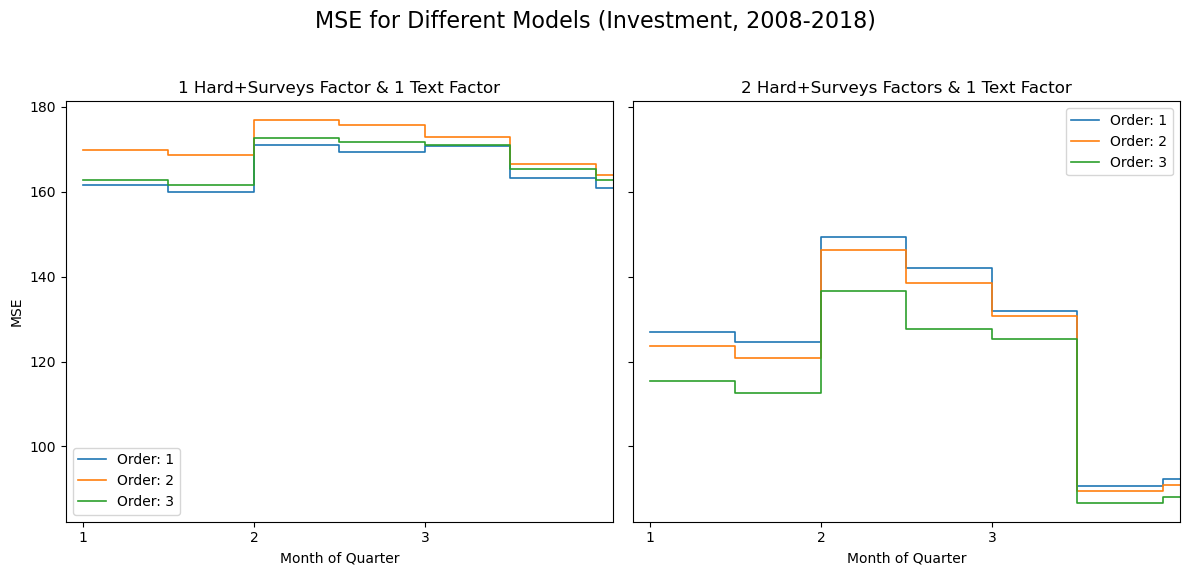

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


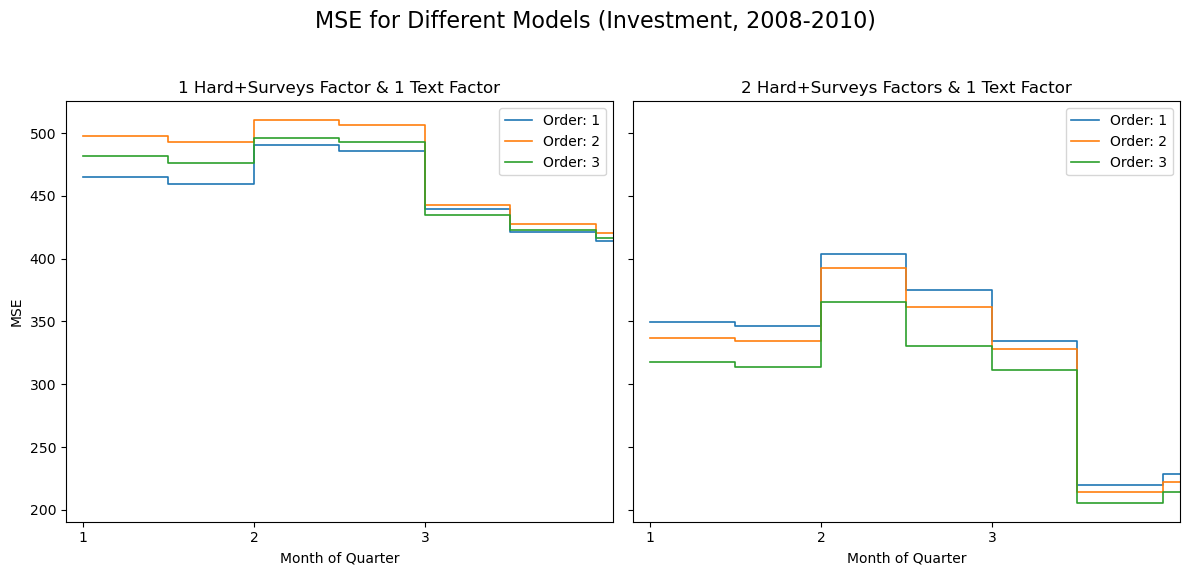

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


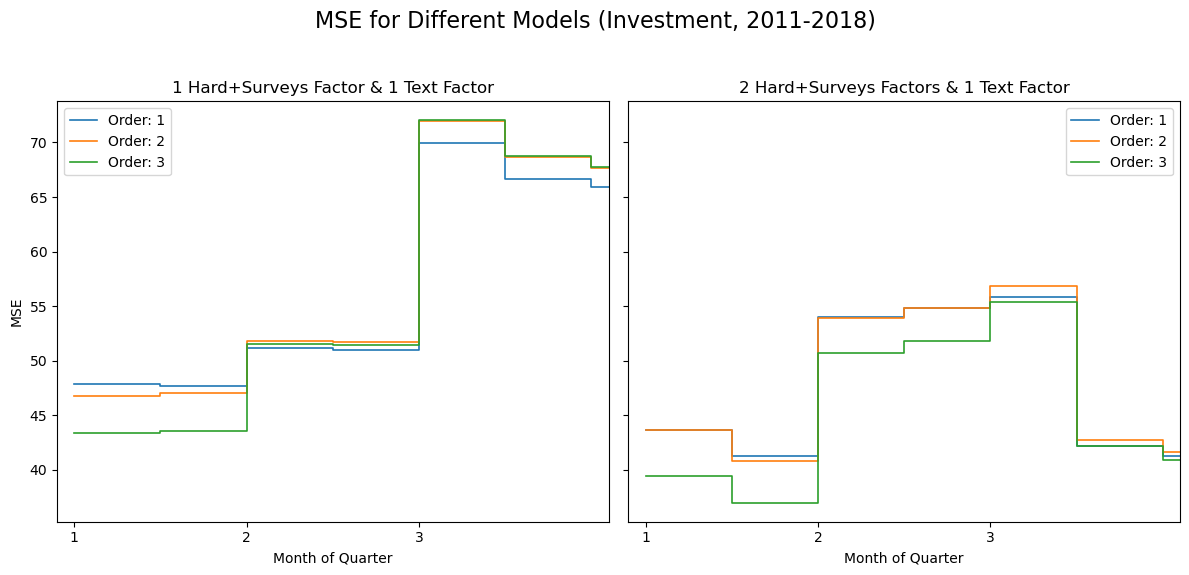

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


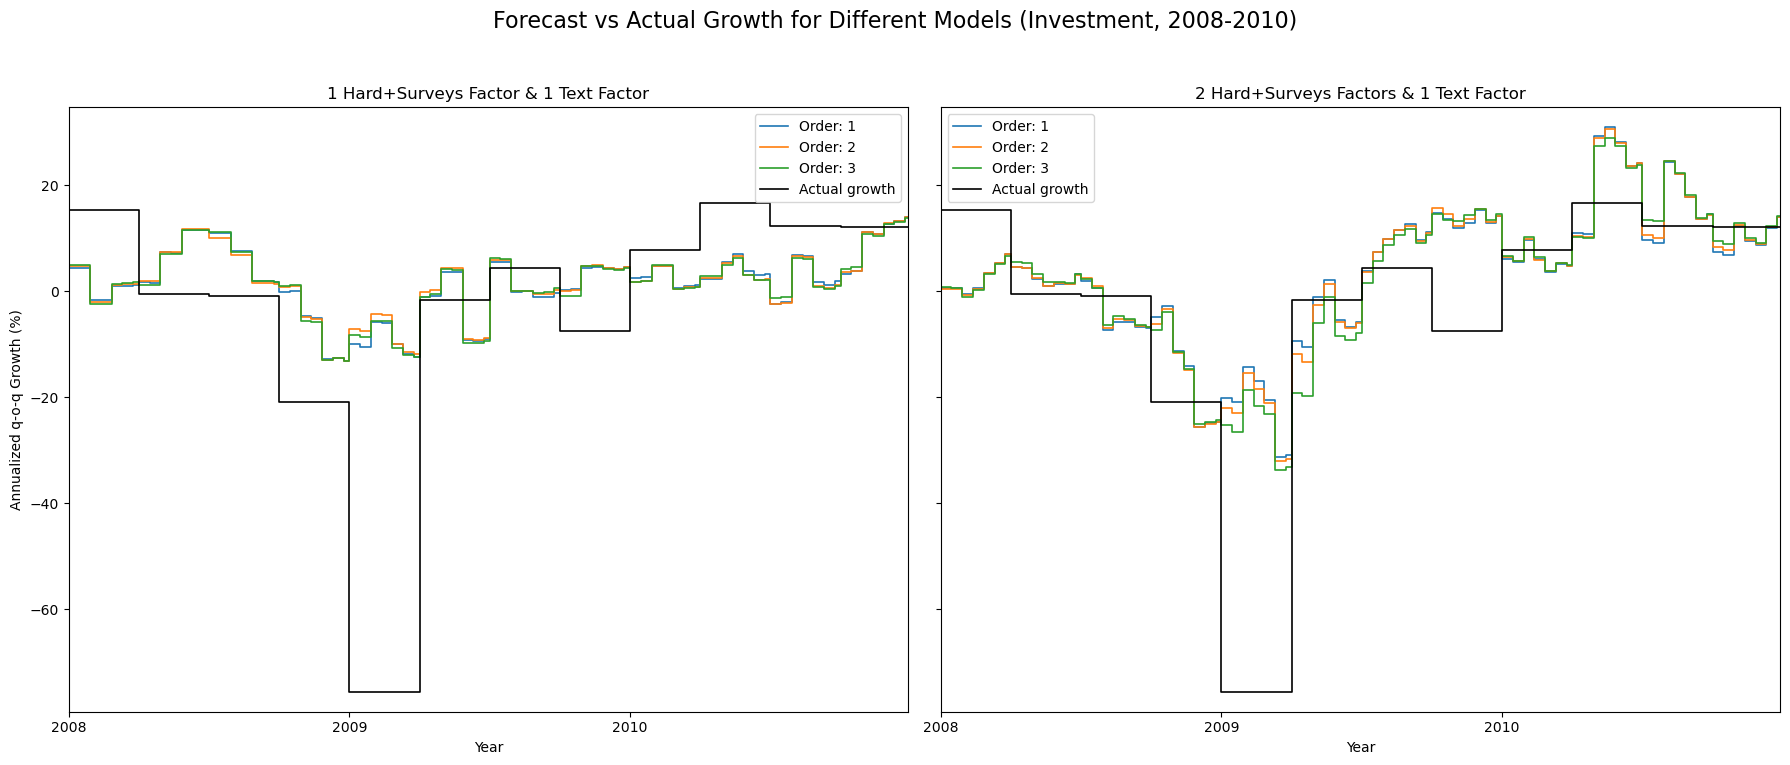

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


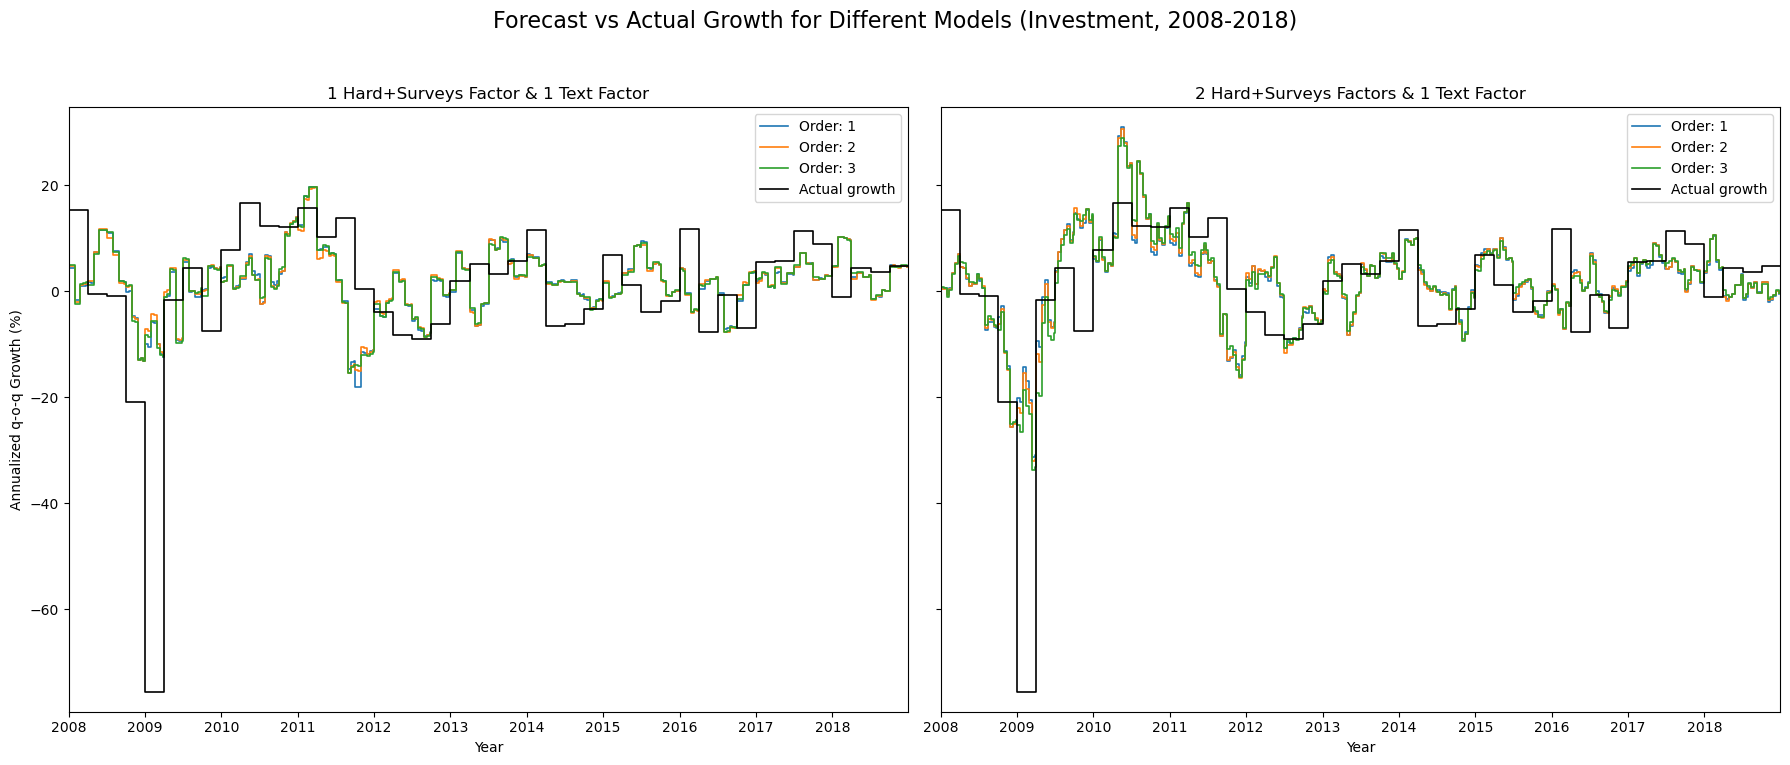

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


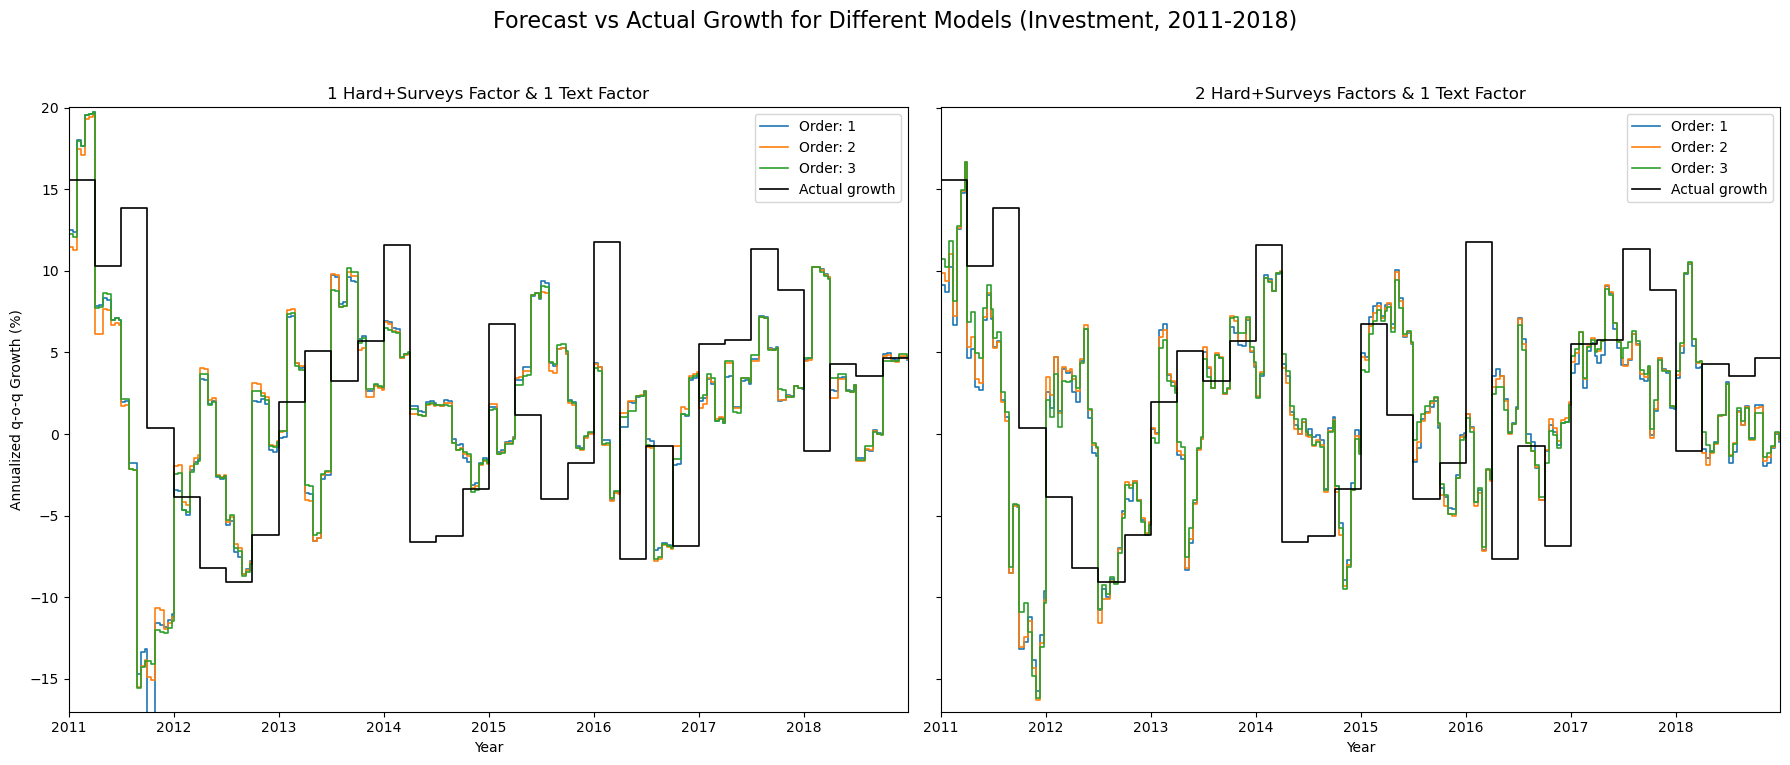

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()